In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(GenomicRanges)
    library(rtracklayer)
    library(scales)
    library(viridis)
    library(matrixStats)
});
options(repr.plot.width=2, repr.plot.height=2, jupyter.plot_mimetypes = "image/svg+xml", digits=3);
theme_set(theme_classic(base_family = "Lucida Sans"));
mycols = c( 'gray', 'firebrick', 'forestgreen' );

In [2]:
# Download from https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE60456&format=file
TSS = import("./data/tss_all_gm12878.bed.gz");

xcols = c(cl1 = "character", cl2="character");
dTSS = import( "./data/hg19.gm12878.pair.div.bed.gz", format='bed', extraCols=xcols );

In [3]:
# load GRO-cap signal; also from GSE60456
bwpl = import( "./data/groseq_gm12878_wTAP_plus.bw" , which=TSS[strand(TSS) == "+"] );
bwmn = import( "./data/groseq_gm12878_wTAP_minus.bw", which=TSS[strand(TSS) == "-"] );
strand(bwpl) = "+";
strand(bwmn) = "-";
bwmn$score = abs(bwmn$score);
bwTSS = append( bwpl, bwmn );
rm(bwpl, bwmn);

# sort so higher scores come first
bwTSS = bwTSS[order(bwTSS$score, decreasing=T)];
TSS$ID = 1:length(TSS);
hits = findOverlaps( bwTSS, TSS );
bwTSS$ID[hits@from] = TSS$ID[hits@to];
# remove duplicated IDs = remove weaker TSSs
bwTSS = bwTSS[!duplicated(bwTSS$ID)];
bwTSS = bwTSS[order(bwTSS$ID)];

TSS = promoters(bwTSS, upstream=200, downstream=30);

In [4]:
getLargestOverlap = function( query, subject ) {
    hits = findOverlaps(query, subject);
    overlaps = width(pintersect(query[hits@from], subject[hits@to]));
    
    # sort by overlap size (largest on top)
    hits = as.matrix(hits)[ order(overlaps, decreasing=T), ];
    # remove duplicates = smaller overlaps
    hits = hits[ !duplicated(hits[,1]), ];
    return(hits);
}

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     20      38      48     120     104    2806 

Warning message:
“Removed 45844 rows containing non-finite values (stat_density).”


[1] 117613

[1] 110438

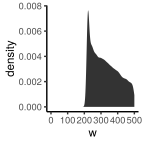

In [5]:
# load DHS peaks and chromHMM class
npcols = c(signalValue = "numeric", pValue = "numeric", qValue = "numeric", peak = "integer");
dhspk = import("./data/E116-DNase.macs2.narrowPeak.gz", format="bed", extraCols=npcols);
chromHMM = import("./data/E116_18_core_K27ac_mnemonics.bed.gz");

# focus on strong DHS peaks
summary(dhspk$score)
dhspk = dhspk[ dhspk$score > median(dhspk$score) ];
# resize small peaks to 100 bp
dhspk[ width(dhspk) <= 100 ] = resize(dhspk[ width(dhspk) <= 100 ], width=100, fix="center");
# add 60bp on each side (as is done for TSSs)
start(dhspk) = start(dhspk)-60;
end(dhspk) = end(dhspk)+60;
# plot new size distribution
ggplot(data=data.frame(w=width(dhspk)), aes(w)) + stat_density() + xlim(0, 500)

# focus on TSSs supported by DHS (>90%), probably non-biological batch effect
length(TSS)
TSS = subsetByOverlaps(TSS, dhspk);
length(TSS)

In [6]:
# for this analysis, we need isolated unpaired TSSs, so remove
# any TSSs that overlap another.
hits = findOverlaps(TSS, TSS, ignore.strand=T);
hits = hits[ hits@from != hits@to ];
TSS = TSS[-unique(hits@from)];
length(TSS);

[1] 24091

In [7]:
mcols(TSS) = NULL;
mcols(dTSS) = NULL;
dpks = dhspk;
mcols(dhspk) = NULL;

# define DHS as untranscribed, TSSs as transcribed
dhspk$class = 0;
TSS$class = 1;
dTSS$class = 1;

# find single and divergent TSS overlaps
sngh = findOverlaps( dhspk,  TSS );
divh = findOverlaps( dhspk, dTSS );
# transcribed DHS = overlap single or divergent TSS
transcribed = unique( c(sngh@from, divh@from) );

# remove transcribed DHS
dhspk = dhspk[-transcribed];
dTSS = dTSS[ unique(divh@to) ];
# remove divergent TSSs
TSS = TSS[ unique(sngh@to[!sngh@from %in% divh@from]) ];

ActPk = c( dhspk, TSS );#, dTSS );

In [8]:
load("./data/HiDRA_voom.Rdata");
length(HiDRA);
sum(HiDRA$p < 0.1);

[1] 9036209

[1] 395100

In [9]:
# find overlapping fragments on opposite strands
Fpl = HiDRA[strand(HiDRA) == "+"];
Fmn = HiDRA[strand(HiDRA) == "-"];
hits = findOverlaps(Fpl, Fmn, ignore.strand=T, minoverlap=90);
# compute fraction overlap
foverlap = width(pintersect(Fpl[hits@from], Fmn[hits@to], ignore.strand=T)) / rowMaxs(cbind(width(Fpl[hits@from]), width(Fmn[hits@to])));
# require >90% overlap
hits = hits[foverlap >= 0.90];
sum(!duplicated(hits@from)) + sum(!duplicated(hits@to));
hits = hits[!duplicated(hits@from) | !duplicated(hits@to)];
Fds = Fpl[hits@from];
Fmn = Fmn[hits@to];
Fds$Fwd = Fds$Ratio;
Fds$Rev = Fmn$Ratio;
Fds$pfwd = Fds$p;
Fds$prev = Fmn$p;

# use intersecting coordinates from both fragments
Fds = pintersect(Fds, Fmn, ignore.strand=T);
Fds = Fds[order(width(Fds), decreasing=T)];

# P_both = P_fwd * P_rev, so we can use alpha = sqrt(0.05) for each direction.
pcol = ifelse((Fds$pfwd <= 0.1 & Fds$Fwd> 0) | (Fds$prev <= 0.1 & Fds$Rev > 0), "Bias", "Inactive");
pcol[Fds$pfwd <= 0.1 & Fds$prev <= 0.1 & Fds$Fwd > 0 & Fds$Rev > 0] = "Enhancer";
Fds$ecall = factor(pcol, levels=c("Inactive", "Bias", "Enhancer"));

Fds$Ratio = NULL;
Fds$DNA=NULL;
Fds$RNA=NULL;

[1] 1151048

Warning message:
“Removed 169 rows containing non-finite values (stat_binhex).”
Warning message:
“Removed 20 rows containing missing values (geom_hex).”


Inactive     Bias Enhancer 
  729846    45539    11401

  cor 
0.072 


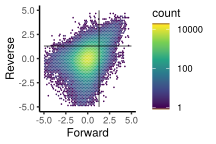

In [10]:
# assess orientation bias of all HiDRA fragments
options(repr.plot.width=3, repr.plot.height=2);
print(
    ggplot(data=as.data.frame(mcols(Fds)), aes(x=Fwd, y=Rev)) +
    geom_hex(bins=60) +
    geom_line( data=data.frame(), aes( x=1.3, y=-5:5 ), col="black", alpha=0.5) +
    geom_line( data=data.frame(), aes( x=-5:5, y=1.3 ), col="black", alpha=0.5) +
    scale_fill_viridis_c(trans="log10", limits=c(1, 10^4.2)) +
    xlim(-5, 5) + ylim(-5, 5) + xlab("Forward") + ylab("Reverse")
);
#ggsave("./out/HiDRA_FvRplot.pdf", width=3, height=2);
summary(factor(Fds$ecall));
print( round( cor.test(Fds$Fwd, Fds$Rev)$estimate^2, 3 ) );

Inactive     Bias Enhancer 
    1994      169       79

 cor 
0.12 


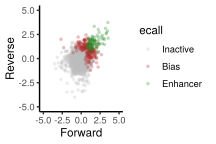

In [11]:
# subset on fragments derived from DHS (transcribed or untranscribed)
hits = findOverlaps( ActPk, Fds, type='within', minoverlap=150 );
hits = hits[!duplicated(hits@from)];
hpk = ActPk[hits@from];
hpk$Fwd = Fds$Fwd[hits@to];
hpk$Rev = Fds$Rev[hits@to];
hpk$pfwd = Fds$pfwd[hits@to];
hpk$prev = Fds$prev[hits@to];
hpk$ecall = Fds$ecall[hits@to];

print(
    ggplot(data=as.data.frame(mcols(hpk[order(hpk$ecall)])), aes(x=Fwd, y=Rev, col = ecall)) +
    geom_point(size=0.8, shape=16, alpha=0.3) +
    scale_color_manual(values=mycols) +
    xlim(-5, 5) + ylim(-5, 5) + xlab("Forward") + ylab("Reverse")
);
#ggsave("./out/HiDRA_DHS_FvR.pdf", width=3, height=2);

summary(factor(hpk$ecall));
print( round( cor.test(hpk$Fwd, hpk$Rev)$estimate^2, 3 ) );

In [12]:
# Now classify according to ChromHMM
hits = findOverlaps( ActPk, Fds );
hits = hits[!duplicated(hits@from)];
ActF = Fds[unique(hits@to)];
length(ActF)
# use chromHMM class with largest overlap on element
hits = getLargestOverlap(ActF, chromHMM);
ActF$cHMM[hits[,1]] = chromHMM$name[ hits[,2] ];
phmm = ActF$cHMM;
phmm[ !substr(phmm, 1, 2) %in% c("1_", "3_", "9_") ] = "99";
phmm = factor(substr(phmm, 1, 2));
levels(phmm) = c("TSS", "UpTSS", "Enh", "Other");
ActF$cHMM = phmm;

[1] 37695

In [13]:
hits = getLargestOverlap(hpk, chromHMM);
hpk$cHMM[hits[,1]] = chromHMM$name[ hits[,2] ];
phmm = hpk$cHMM;
phmm[ !substr(phmm, 1, 2) %in% c("1_", "3_", "9_") ] = "99";
phmm = factor(substr(phmm, 1, 2));
levels(phmm) = c("TSS", "UpTSS", "Enh", "Other");
hpk$cHMM = phmm;

In [14]:
hpk$etype = factor( ifelse( hpk$ecall == "Enhancer", "Enhancer", "Inactive" ) );
hpk$class = factor( hpk$class );
levels(hpk$class) = c("Untranscibed", "Transcribed");

out = as.data.frame( mcols(hpk) ) %>%
    group_by(cHMM, class, etype) %>%
    tally() %>%
    mutate( tot=sum(n), pct = 100*n / tot,
            lower = pct - 100*sqrt( pct*(100-pct)/tot/1E4 ),
            upper = pct + 100*sqrt( pct*(100-pct)/tot/1E4 ) );
out = out %>% filter(etype == "Inactive");
out

cHMM,class,etype,n,tot,pct,lower,upper
<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>
TSS,Untranscibed,Inactive,161,161,100.0,100.0,100.0
TSS,Transcribed,Inactive,326,338,96.4,95.4,97.5
UpTSS,Untranscibed,Inactive,233,235,99.1,98.5,99.7
UpTSS,Transcribed,Inactive,403,422,95.5,94.5,96.5
Enh,Untranscibed,Inactive,88,89,98.9,97.8,100.0
Enh,Transcribed,Inactive,101,119,84.9,81.6,88.2
Other,Untranscibed,Inactive,605,615,98.4,97.9,98.9
Other,Transcribed,Inactive,246,263,93.5,92.0,95.1


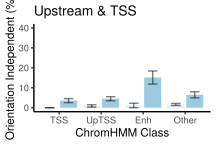

In [15]:
ggplot(out, aes(x=cHMM, y=100-pct, ymin=100-lower, ymax=100-upper, fill=class)) +
    coord_cartesian(ylim=c(0, 40)) +
    geom_col( pos=position_dodge2(), show.legend = F ) +
    geom_errorbar( pos=position_dodge2(width=0.5, padding=0.5), alpha=0.5, show.legend = F ) +
    scale_fill_brewer("Type") +
    ylab("Orientation Independent (%)") +
    xlab("ChromHMM Class") +
    ggtitle("Upstream & TSS");
#ggsave("./out/HiDRA_Full_ChromHMM.pdf", width=3, height=2);

In [16]:
# focus on sequences flanking DHS
fdhs = dhspk;
start(fdhs) = end(fdhs) - 70;
end(fdhs) = end(fdhs) + 180;
fdhs = append( fdhs, promoters(dhspk, upstream=180, downstream=70) );

# swap strands so start = end, allowing use of 'promoter' function
inTSS = TSS;
strand(inTSS) = ifelse(strand(inTSS) == "+", "-", "+");
inTSS = promoters(inTSS, upstream=70, downstream=180);

mcols(inTSS) = NULL;
fdhs$class = 0;
inTSS$class = 1;

In [17]:
flank_hpk = c( fdhs, inTSS ); # , indTSS );
hits = findOverlaps( flank_hpk, Fds, type='within' );
hits = hits[!duplicated(hits@from)];
flank_hpk = flank_hpk[hits@from];
flank_hpk$Fwd = Fds$Fwd[hits@to];
flank_hpk$Rev = Fds$Rev[hits@to];
flank_hpk$pfwd = Fds$pfwd[hits@to];
flank_hpk$prev = Fds$prev[hits@to];
flank_hpk$ecall = Fds$ecall[hits@to];

hits = getLargestOverlap(flank_hpk, chromHMM);
flank_hpk$cHMM[hits[,1]] = chromHMM$name[ hits[,2] ];
phmm = flank_hpk$cHMM;
phmm[ !substr(phmm, 1, 2) %in% c("1_", "3_", "9_") ] = "99";
phmm = factor(substr(phmm, 1, 2));
levels(phmm) = c("TSS", "UpTSS", "Enh", "Other");
flank_hpk$cHMM = phmm;

flank_hpk$etype = factor(ifelse(flank_hpk$ecall == "Enhancer", "Enhancer", "Inactive"));
flank_hpk$class = factor( flank_hpk$class );
levels(flank_hpk$class) = c("Untranscibed", "Transcribed");

In [18]:
out = as.data.frame(mcols(flank_hpk)) %>%
    group_by(cHMM, class, etype) %>%
    tally() %>%
    mutate( tot=sum(n), pct = 100*n / tot,
            lower = pct - 100*sqrt( pct*(100-pct)/tot/1E4 ),
            upper = pct + 100*sqrt( pct*(100-pct)/tot/1E4 ) );
out = out %>% filter(etype == "Inactive");
out

cHMM,class,etype,n,tot,pct,lower,upper
<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>
TSS,Untranscibed,Inactive,1691,1697,99.6,99.5,99.8
TSS,Transcribed,Inactive,255,261,97.7,96.8,98.6
UpTSS,Untranscibed,Inactive,3268,3293,99.2,99.1,99.4
UpTSS,Transcribed,Inactive,392,408,96.1,95.1,97.0
Enh,Untranscibed,Inactive,1510,1517,99.5,99.4,99.7
Enh,Transcribed,Inactive,72,78,92.3,89.3,95.3
Other,Untranscibed,Inactive,13144,13209,99.5,99.4,99.6
Other,Transcribed,Inactive,156,164,95.1,93.4,96.8


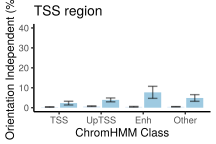

In [19]:
ggplot(out, aes(x=cHMM, y=100-pct, ymin=100-lower, ymax=100-upper, fill=class)) +
    coord_cartesian(ylim=c(0, 40)) +
    geom_col( pos=position_dodge2(), show.legend = F ) +
    geom_errorbar( pos=position_dodge2(width=0.5, padding=0.5), alpha=0.5, show.legend = F ) +
    scale_fill_brewer("Type") +
    ylab("Orientation Independent (%)") +
    xlab("ChromHMM Class") + 
    ggtitle("TSS region");
#ggsave("./out/HiDRA_Flank_ChromHMM.pdf", width=3, height=2);

In [20]:
# "central" sequences not defined from untranscribed DHS
indhs = dhspk;
inTSS = promoters(TSS, upstream=300, downstream=width(TSS)[1]-65);

mcols(inTSS) = NULL;
indhs$class = 0;
inTSS$class = 1;

In [21]:
central_hpk = c( indhs, inTSS ); #, indTSS );

hits = findOverlaps( Fds, central_hpk, type='within' );#, type='end', maxgap=10 );
hits = hits[!duplicated(hits@to)];
central_hpk = central_hpk[hits@to];
central_hpk$Fwd = Fds$Fwd[hits@from];
central_hpk$Rev = Fds$Rev[hits@from];
central_hpk$pfwd = Fds$pfwd[hits@from];
central_hpk$prev = Fds$prev[hits@from];
central_hpk$ecall = Fds$ecall[hits@from];

hits = getLargestOverlap(central_hpk, chromHMM);
central_hpk$cHMM[hits[,1]] = chromHMM$name[ hits[,2] ];
phmm = central_hpk$cHMM;
phmm[ !substr(phmm, 1, 2) %in% c("1_", "3_", "9_") ] = "99";
phmm = factor(substr(phmm, 1, 2));
levels(phmm) = c("TSS", "UpTSS", "Enh", "Other");
central_hpk$cHMM = phmm;

central_hpk$etype = factor(ifelse(central_hpk$ecall == "Enhancer", "Enhancer", "Inactive"));
central_hpk$class = factor( central_hpk$class );
levels(central_hpk$class) = c("Untranscibed", "Transcribed");

In [22]:
out = as.data.frame( mcols(central_hpk) ) %>%
    group_by(cHMM, class, etype) %>%
    tally() %>%
    mutate( tot=sum(n), pct = 100*n / tot,
            lower = pct - 100*sqrt( pct*(100-pct)/tot/1E4 ),
            upper = pct + 100*sqrt( pct*(100-pct)/tot/1E4 ) );
out = out %>% filter(etype == "Inactive");
out

cHMM,class,etype,n,tot,pct,lower,upper
<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>
TSS,Untranscibed,Inactive,1109,1127,98.4,98.0,98.8
TSS,Transcribed,Inactive,461,466,98.9,98.4,99.4
UpTSS,Untranscibed,Inactive,2991,3070,97.4,97.1,97.7
UpTSS,Transcribed,Inactive,814,842,96.7,96.1,97.3
Enh,Untranscibed,Inactive,1073,1143,93.9,93.2,94.6
Enh,Transcribed,Inactive,238,245,97.1,96.1,98.2
Other,Untranscibed,Inactive,5734,5843,98.1,98.0,98.3
Other,Transcribed,Inactive,676,690,98.0,97.4,98.5


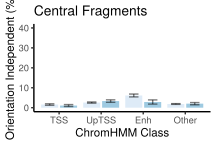

In [23]:
ggplot(out, aes(x=cHMM, y=100-pct, ymin=100-lower, ymax=100-upper, fill=class, label=tot-n)) +
    coord_cartesian(ylim=c(0, 40)) +
    geom_col( pos=position_dodge2(), show.legend = F ) +
    geom_errorbar( pos=position_dodge2(width=0.5, padding=0.5), alpha=0.5, show.legend = F ) +
    scale_fill_brewer("Type") +
    ylab("Orientation Independent (%)") +
    xlab("ChromHMM Class") + 
    ggtitle("Central Fragments");
#ggsave("./out/HiDRA_Central_ChromHMM.pdf", width=3, height=2);

In [24]:
lm_eqn = function(form, df) {
    m = lm(form, df);
    eq = substitute(italic(r)~"="~r2~"  "~italic(p) == pv,
        list(pv = format(anova(m)[1,5], digits = 2),
             r2 = format(sqrt(summary(m)$r.squared), digits = 2)))
    as.character(as.expression(eq));                 
}

cHMM,class,ecall,n,tot,pct,lower,upper
<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>
TSS,Untranscibed,Bias,7,161,4.35,2.741,5.96
TSS,Transcribed,Bias,40,338,11.83,10.077,13.59
UpTSS,Untranscibed,Bias,4,235,1.70,0.858,2.55
UpTSS,Transcribed,Bias,47,422,11.14,9.606,12.67
Enh,Untranscibed,Bias,7,89,7.87,5.012,10.72
Enh,Transcribed,Bias,11,119,9.24,6.589,11.90
Other,Untranscibed,Bias,29,615,4.72,3.861,5.57
Other,Transcribed,Bias,24,263,9.13,7.350,10.90


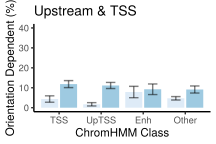

In [25]:
out = as.data.frame( mcols(hpk) ) %>%
    group_by(cHMM, class, ecall) %>%
    tally() %>%
    mutate( tot=sum(n), pct = 100*n / tot,
            lower = pct - 100*sqrt( pct*(100-pct)/tot/1E4 ),
            upper = pct + 100*sqrt( pct*(100-pct)/tot/1E4 ) ) %>%
    filter( ecall == "Bias" );
out
options(repr.plot.width=3, repr.plot.height=2);
ggplot(out, aes(x=cHMM, y=pct, ymin=lower, ymax=upper, fill=class, label=tot-n)) +
    coord_cartesian(ylim=c(0, 40)) +
    geom_col( pos=position_dodge2(), show.legend = F ) +
    geom_errorbar( pos=position_dodge2(width=0.5, padding=0.5), alpha=0.5, show.legend = F ) +
    scale_fill_brewer("Type") +
    ylab("Orientation Dependent (%)") +
    xlab("ChromHMM Class") + 
    ggtitle("Upstream & TSS");
#ggsave("./out/HiDRA_OriBias_Full.pdf", width=3, height=2);

cHMM,class,ecall,n,tot,pct,lower,upper
<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>
TSS,Untranscibed,Bias,96,1127,8.52,7.69,9.35
TSS,Transcribed,Bias,34,466,7.30,6.09,8.50
UpTSS,Untranscibed,Bias,247,3070,8.05,7.55,8.54
UpTSS,Transcribed,Bias,56,842,6.65,5.79,7.51
Enh,Untranscibed,Bias,107,1143,9.36,8.50,10.22
Enh,Transcribed,Bias,26,245,10.61,8.64,12.58
Other,Untranscibed,Bias,364,5843,6.23,5.91,6.55
Other,Transcribed,Bias,31,690,4.49,3.70,5.28


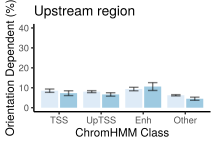

In [26]:
out = as.data.frame( mcols(central_hpk) ) %>%
    group_by(cHMM, class, ecall) %>%
    tally() %>%
    mutate( tot=sum(n), pct = 100*n / tot,
            lower = pct - 100*sqrt( pct*(100-pct)/tot/1E4 ),
            upper = pct + 100*sqrt( pct*(100-pct)/tot/1E4 ) ) %>%
    filter( ecall == "Bias" );
out
ggplot(out, aes(x=cHMM, y=pct, ymin=lower, ymax=upper, fill=class, label=tot-n)) +
    coord_cartesian(ylim=c(0, 40)) +
    geom_col( pos=position_dodge2(), show.legend = F ) +
    geom_errorbar( pos=position_dodge2(width=0.5, padding=0.5), alpha=0.5, show.legend = F ) +
    scale_fill_brewer("Type") +
    ylab("Orientation Dependent (%)") +
    xlab("ChromHMM Class") + 
    ggtitle("Upstream region");
#ggsave("./out/HiDRA_OriBias_Central.pdf", width=3, height=2);

cHMM,class,ecall,n,tot,pct,lower,upper
<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>
TSS,Untranscibed,Bias,72,1697,4.24,3.75,4.73
TSS,Transcribed,Bias,24,261,9.20,7.41,10.98
UpTSS,Untranscibed,Bias,120,3293,3.64,3.32,3.97
UpTSS,Transcribed,Bias,41,408,10.05,8.56,11.54
Enh,Untranscibed,Bias,80,1517,5.27,4.70,5.85
Enh,Transcribed,Bias,8,78,10.26,6.82,13.69
Other,Untranscibed,Bias,414,13209,3.13,2.98,3.29
Other,Transcribed,Bias,11,164,6.71,4.75,8.66


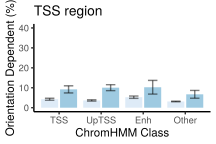

In [27]:
out = as.data.frame( mcols(flank_hpk) ) %>%
    group_by(cHMM, class, ecall) %>%
    tally() %>%
    mutate( tot=sum(n), pct = 100*n / tot,
            lower = pct - 100*sqrt( pct*(100-pct)/tot/1E4 ),
            upper = pct + 100*sqrt( pct*(100-pct)/tot/1E4 ) ) %>%
    filter( ecall == "Bias" );
out

ggplot(out, aes(x=cHMM, y=pct, ymin=lower, ymax=upper, fill=class, label=tot-n)) +
    coord_cartesian(ylim=c(0, 40)) +
    geom_col( pos=position_dodge2(), show.legend = F ) +
    geom_errorbar( pos=position_dodge2(width=0.5, padding=0.5), alpha=0.5, show.legend = F ) +
    scale_fill_brewer("Type") +
    ylab("Orientation Dependent (%)") +
    xlab("ChromHMM Class") + 
    ggtitle("TSS region");
#ggsave("./out/HiDRA_OriBias_Flanking.pdf", width=3, height=2);